In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
from train import MCTS_HYPERPARAMETERS, load_from_checkpoint, collect_episode, train, rotate_training_examples
import torch
from model_3d import MonteCarlo3d
from utils import input_to_tensor_3d
import torch.multiprocessing as mp
from train import save_checkpoint, load_from_checkpoint, ReplayMemory, MetricsHistory
import IPython.display as display
import matplotlib.pyplot as plt
import time


In [2]:
MODEL_TO_LOAD = "" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True
PLOT_EVERY = 50

# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hyperparameters = MCTS_HYPERPARAMETERS() # use kwargs to specify non-default values


In [3]:
if MODEL_TO_LOAD:
    _, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, MonteCarlo3d, load_replay_memory=LOAD_REPLAY_MEMORY)
    metrics_history.figs = [plt.figure() for _ in range(6)]
else:
    hyperparameters.replay_memory_size = 480000
    hyperparameters.minibatch_size = 1024
    hyperparameters.weight_decay = 0.0005
    hyperparameters.num_mcts_train_evals = 500
    hyperparameters.num_episodes = 100000
    hyperparameters.mcts_c_puct = 3
    hyperparameters.minibatches_per_episode = 4
    hyperparameters.lr = 1e-4
    hyperparameters.mcts_tau = 0.4
    model = MonteCarlo3d()
    replay_memory = ReplayMemory(hyperparameters.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay)
    metrics_history = MetricsHistory()
    run_tag = 'no4'     
    episode = 0
    
    
NUM_PROCS = 29

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

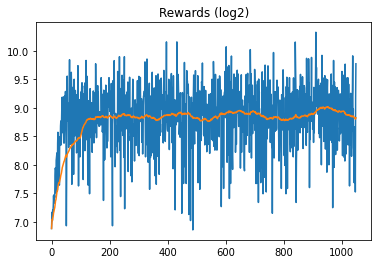

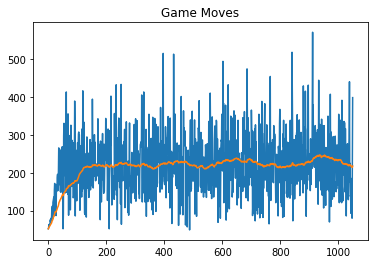

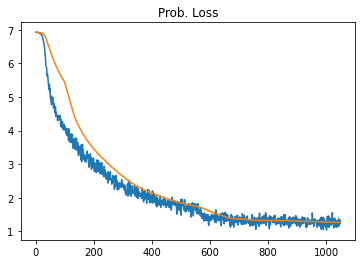

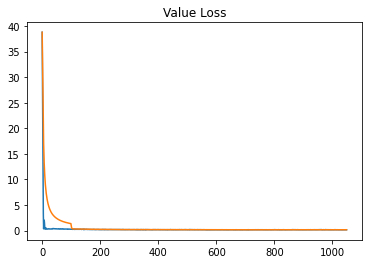

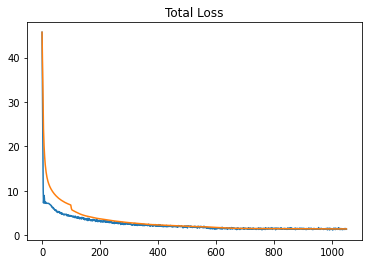

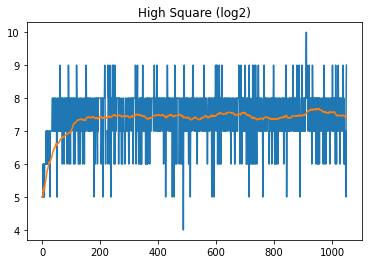

[EPISODE 1050] Total Loss: 1.4014776411720578, Prob Loss 1.24022316069091, Value Loss 0.16125448048114777, Reward 9.7714894695006, Moves: 399, Highest Square: 9, PID: 123776
[EPISODE 1051] Total Loss: 1.4022380930079623, Prob Loss 1.2310660850896045, Value Loss 0.17117200791835785, Reward 9.233619676759702, Moves: 271, Highest Square: 8, PID: 123771
[EPISODE 1052] Total Loss: 1.4514417742893109, Prob Loss 1.2968375181362042, Value Loss 0.1546042561531067, Reward 8.417852514885897, Moves: 151, Highest Square: 7, PID: 123778
[EPISODE 1053] Total Loss: 1.543355180988973, Prob Loss 1.3482728145224507, Value Loss 0.19508236646652222, Reward 9.224001674198105, Moves: 269, Highest Square: 8, PID: 123757
[EPISODE 1054] Total Loss: 1.3582459592927347, Prob Loss 1.1932798379767786, Value Loss 0.16496612131595612, Reward 8.499845887083206, Moves: 159, Highest Square: 7, PID: 123766
[EPISODE 1055] Total Loss: 1.2728494375649289, Prob Loss 1.1172842651310757, Value Loss 0.15556517243385315, Reward 

Process ForkPoolWorker-12:
Process ForkPoolWorker-4:
Process ForkPoolWorker-20:
Process ForkPoolWorker-16:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:
Process ForkPoolWorker-11:
Process ForkPoolWorker-25:
Process ForkPoolWorker-29:
Process ForkPoolWorker-13:
Process ForkPoolWorker-19:
Process ForkPoolWorker-14:
Process ForkPoolWorker-3:
Process ForkPoolWorker-18:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Process ForkPoolWorker-26:
Traceback (most recent call last):
Process ForkPoolWorker-17:
Traceback (most recent call last):
Process ForkPoolWorker-5:
Traceback (most recent call last):
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-15:
Process ForkPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
Tr

[EPISODE 1057] Total Loss: 1.3860646142177124, Prob Loss 1.226597855847313, Value Loss 0.15946675837039948, Reward 8.426264754702098, Moves: 150, Highest Square: 7, PID: 123780


KeyboardInterrupt: 

In [4]:
def enque_and_train(results):
    torch.set_num_threads(1)
    training_examples, reward, moves, high_square, pid = results
    training_examples = rotate_training_examples(training_examples)
    replay_memory.extend(training_examples)
    
    if replay_memory.size() >= hyperparameters.minibatch_size:
        for i in range(hyperparameters.minibatches_per_episode):
            value_loss, prob_loss, total_loss = train(replay_memory.sample(hyperparameters.minibatch_size), model, optimizer, tensor_conversion_fn=input_to_tensor_3d)
        
        new_best = metrics_history.add_history({
            'reward': reward,
            'game_moves': moves,
            'prob_loss': prob_loss,
            'value_loss': value_loss,
            'total_loss': total_loss,
            'high_square': high_square
        })
        if metrics_history.episodes % PLOT_EVERY == 0:
            metrics_history.plot_history(window_size=100)
        
        if new_best:
            print(f'*** NEW BEST REWARD: {metrics_history.best_result} ***')
        
        print(f'[EPISODE {metrics_history.episodes}] Total Loss: {total_loss}, Prob Loss {prob_loss}, Value Loss {value_loss}, Reward {reward}, Moves: {moves}, Highest Square: {high_square}, PID: {pid}')
        if metrics_history.episodes % hyperparameters.checkpoint_every == 0:
            print('Saving model checkpoint...')
            save_checkpoint(metrics_history.episodes, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag=run_tag, save_replay_memory=True)
            print('Saved model checkpoint!')
    else:
        print(f'Replay memory size not large enough, {replay_memory.size()} < {hyperparameters.minibatch_size}')
    
with mp.Pool(NUM_PROCS) as p:
    results = []
    for n in range(metrics_history.episodes, hyperparameters.num_episodes):
        results.append(p.apply_async(collect_episode, (model, hyperparameters, input_to_tensor_3d, ), callback=enque_and_train, error_callback=print))
    for r in results:
        r.wait()